**Data Exploration (EDA)**
---

**1.1**  Import Packages

---

In [96]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt 
import numpy as np 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz
from sklearn import tree
import warnings
warnings.filterwarnings("ignore")

**1.2** Connect database and pandas

---

In [2]:
conn = sqlite3.connect('cafe_insomnia.sqlite')

cafe = pd.read_sql('''SELECT c.id, c.days_after_open, c.day_of_week, c.hours_after_open, c.drink_id, c.quantity, c.raining, s.name, s.dist_to_cafe, d.name, d.unit_price
                      FROM ci_transaction c
                      JOIN study_area s
                      ON c.study_area_id = s.id
                      JOIN drink d
                      ON d.id = c.drink_id
                      ;''',conn)

In [3]:
# Cheak missing value
cafe.isnull().sum()

id                  0
days_after_open     0
day_of_week         0
hours_after_open    0
drink_id            0
quantity            0
raining             0
name                0
dist_to_cafe        0
name                0
unit_price          0
dtype: int64

**1.3** Exploring dataset

---

Summaring Quantity saled per order and price per unit as Total revenue for each order

In [4]:
cafe['order_price'] = np.multiply(cafe['quantity'],cafe['unit_price'])

In [5]:
#Delet unnecessary column
del cafe['quantity']
del cafe['unit_price']

Checking our dataset, and we found overlap between the building name and coffee name

In [6]:
cafe

,id,days_after_open,day_of_week,hours_after_open,drink_id,raining,name,dist_to_cafe,name,order_price
0,0,0,Mon,0,5,No,Abercrombie (H70),700,Flat White (L),4.9
1,1,0,Mon,0,5,No,Law Library (F10),84,Flat White (L),4.9
2,2,0,Mon,0,2,No,Carslaw (F07),150,Macchiato,3.8
3,3,0,Mon,0,2,No,Peter Nicol Russell (PNR),950,Macchiato,3.8
4,4,0,Mon,0,5,No,Carslaw (F07),150,Flat White (L),4.9
...,...,...,...,...,...,...,...,...,...,...
27166,27709,153,Sun,5,14,No,Abercrombie (H70),700,Mocha (S),9.0
27167,27710,153,Sun,5,6,No,Abercrombie (H70),700,Flat White (S),4.0
27168,27711,153,Sun,5,12,No,Fisher Library (F03),70,Chai Latte (S),3.6
27169,27712,153,Sun,5,9,No,Brennan MacCallum (A18),350,Cappuccino (L),4.9


In [7]:
#Change name of columns
#1 st name to building name
#2 nd name to coffee name
new_columns = ['id','days_after_open','day_of_week','hours_after_open','drink_id','raining','building_name','dist_to_cafe','cafe_name','order_price']
cafe.columns = new_columns

Statistic describe about quantitative data

In [8]:
cafe.describe()

,id,days_after_open,hours_after_open,drink_id,dist_to_cafe,order_price
count,27171.000000,27171.000000,27171.000000,27171.000000,27171.000000,27171.000000
mean,13853.333002,107.558868,2.376652,8.032829,243.756505,5.327018
std,7996.182672,36.822247,1.682285,4.873674,267.166341,2.695656
min,0.000000,0.000000,0.000000,0.000000,70.000000,3.300000
25%,6934.500000,89.000000,1.000000,4.000000,70.000000,3.800000
50%,13844.000000,117.000000,2.000000,8.000000,84.000000,4.400000
75%,20775.500000,136.000000,4.000000,12.000000,350.000000,4.900000
max,27713.000000,153.000000,5.000000,16.000000,950.000000,21.600000


Checking the type of data

In [9]:
cafe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27171 entries, 0 to 27170
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                27171 non-null  int64  
 1   days_after_open   27171 non-null  int64  
 2   day_of_week       27171 non-null  object 
 3   hours_after_open  27171 non-null  int64  
 4   drink_id          27171 non-null  int64  
 5   raining           27171 non-null  object 
 6   building_name     27171 non-null  object 
 7   dist_to_cafe      27171 non-null  int64  
 8   cafe_name         27171 non-null  object 
 9   order_price       27171 non-null  float64
dtypes: float64(1), int64(5), object(4)
memory usage: 2.1+ MB


Checking each unique value for categorical data:

In [10]:
cafe['raining'].unique(),cafe['building_name'].unique(),cafe['cafe_name'].unique()

(array(['No', 'Yes'], dtype=object),
 array(['Abercrombie (H70)', 'Law Library (F10)', 'Carslaw (F07)',
        'Peter Nicol Russell (PNR)', 'Fisher Library (F03)',
        'Brennan MacCallum (A18)', 'The Quarter (A16)'], dtype=object),
 array(['Flat White (L)', 'Macchiato', 'Cappuccino (L)',
        'Hot Chocolate (S)', 'Chai Latte (L)', 'Long Black (S)',
        'Cappuccino (S)', 'Espresso', 'Latte (S)', 'Flat White (S)',
        'Hot Chocolate (L)', 'Mocha (L)', 'Ristretto', 'Long Black (L)',
        'Chai Latte (S)', 'Mocha (S)', 'Latte (L)'], dtype=object))

In [11]:
# get dummies for dummy variable raining
Israining = pd.get_dummies(cafe['raining'],drop_first = True)
cafe = cafe.join(Israining)
cafe = cafe.rename(columns = {'Yes':'isRaining'})

No missing values, untidy data found

In [12]:
# a simple way to label graph
def autoLabel(x,y,t):
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(t)
    plt.legend()

***2.1 hourly coffee sales with number of days opened***

---

**2.1.1** Reorganize dataframe

In [13]:
#ndarray type values of total coffee sale ($) in each day
ds = cafe.groupby('days_after_open').sum()['order_price'].to_numpy()

#Number of days
day = np.arange(len(ds))

#how many hours open each day
h = cafe['hours_after_open'].nunique()

#Integer number of days
d = len(ds)

#create an adarray with 154 rows and 6 columns in order to store the toal sale in each hour in each day
ones = np.ones((d,h))

# Store values 
for i in range(h):
    for j in range(d):
        hourly_sale = cafe[cafe['hours_after_open']== i].groupby('days_after_open').sum()['order_price'].to_numpy().reshape(-1,1)
        ones[j,i] = hourly_sale[j]
ones_1 = np.concatenate((day.reshape(-1,1),ones),axis =1)

new_df = pd.DataFrame(ones_1,columns = ['day','0','1','2','3','4','5'])

#Calculate mean hourly sales and create column, named by avg_hsale
for i in range(1,d+1):
    new_df['avg_hsale'] = new_df[['0','1','2','3','4','5']][:i].mean(axis=1).round(1)

In [14]:
new_df.head()

,day,0,1,2,3,4,5,avg_hsale
0,0.0,49.0,83.6,37.3,50.6,16.1,43.5,46.7
1,1.0,65.8,41.4,63.3,95.3,46.8,37.3,58.3
2,2.0,92.2,67.1,81.7,33.4,34.1,42.4,58.5
3,3.0,39.1,73.2,67.3,67.0,56.9,11.6,52.5
4,4.0,26.2,46.4,48.8,20.6,41.2,4.4,31.3


**2.1.2** Line plot

In [15]:
# Insert a column of ones for further analyize purpose
new_df.insert(0,'ones',1)

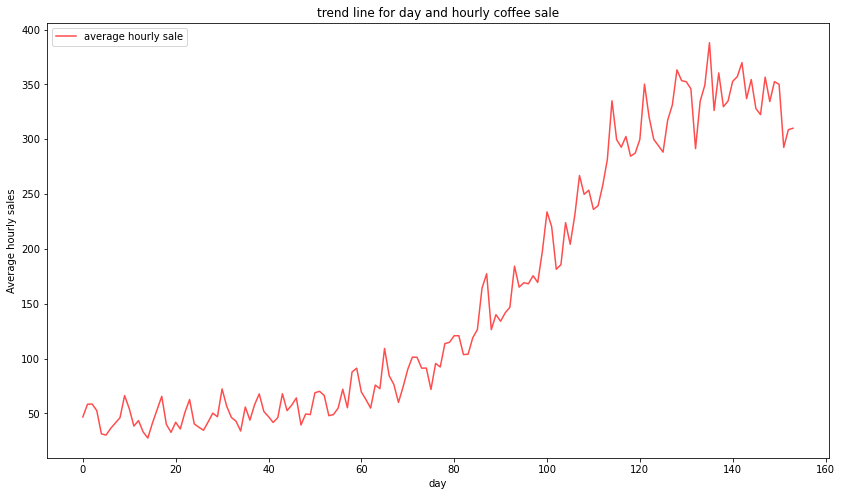

In [16]:
# Set the attribute for the graph
plt.figure(figsize = (14,8))

# plot x: day y: average hourly coffee sale
plt.plot(new_df['day'],new_df['avg_hsale'],linewidth=1.5,c='red',label = 'average hourly sale',alpha = 0.7)
autoLabel('day','Average hourly sales','trend line for day and hourly coffee sale')

**2.1.3** Correlation

In [17]:
r, p_value = pearsonr (new_df['day'].index,new_df['avg_hsale'].values)

#get correlation coefficient,Two-tailed p-value.
#The Pearson correlation coefficient measures the linear relationship between two datasets.

r, p_value

(0.9315357557903933, 1.160205879882224e-68)

In [18]:
#Pearson correlation coefficient and p-value for testing non-correlation.
p_value < 0.05



True

Correlation coefficient close to 1 and reject H0, suggest that there is a linear relationship.

By obervating the graph and  Pearson correlation coefficient measures the linear relationship between two datasets.
We can thus guess a linear relationship between day opened and hourly coffee sale. Scatter plot might demonstrates a more accuarte review of the relationship

**2.1.4** Scatter plot

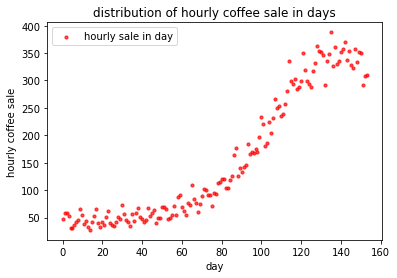

In [19]:
# x :  number of day open
# y :  Average hourly coffee sale
plt.scatter(new_df['day'],new_df['avg_hsale'],color = 'red',alpha = 0.7,s = 10,label = 'hourly sale in day')
autoLabel('day','hourly coffee sale','distribution of hourly coffee sale in days')

According to the scatter plot, we can clearly observe a stablize stage from day 0 to day 6x, and a boosting stage from day 6x today 12x, and a peak stage begins from day 12x. 

we can, thus, assign stage of hourly coffee sale into 3 based on the growth rate of each, which are **begining stage**, **boosting stage** and **peak stage**. A clustering can be applicated to optimally distinguish these 3 stages.

**2.1.5** K-means clustering

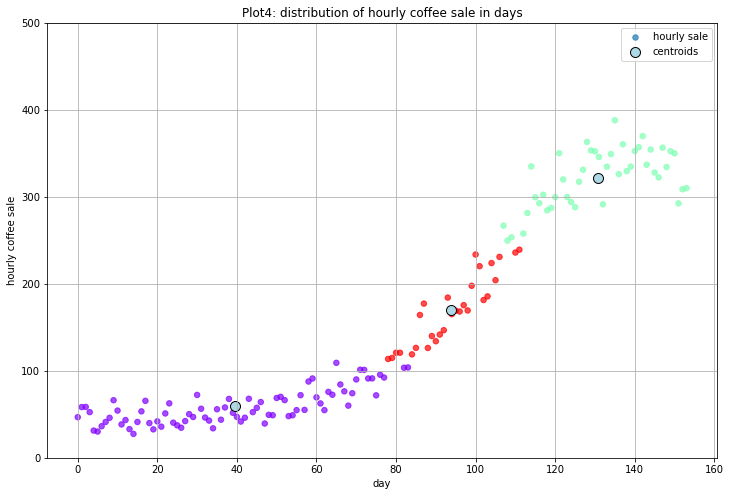

In [20]:
# Set random seed as 0
np.random.seed(0)

# fit clustering with k = 3 
clu = new_df[['day','avg_hsale']].to_numpy()
kmeans = KMeans(n_clusters = 3)
kmeans.fit(clu)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# set size of figure
plt.figure(figsize=(12,8))

# plot the cluster and set relative features
plt.scatter(clu[:,0],clu[:,1],alpha = 0.7,s=30,cmap='rainbow',c =labels,label = 'hourly sale')

# plot the centroids
plt.scatter(centroids[:,0],centroids[:,1],s=100,color = 'lightblue',edgecolor = 'black',label = 'centroids')

# set grid line
plt.grid()

# display fully the plot
plt.ylim([0,500])

# auto label
autoLabel('day','hourly coffee sale','Plot4: distribution of hourly coffee sale in days')

In [21]:
# begining stage dataframe
bg = new_df[new_df['day'] < 79]

# Boom stage dataframe
bm = new_df[(new_df['day'] > 79)&(new_df['day'] < 110)].reset_index()

# Peak stage dataframe
pk = new_df[new_df['day'] > 109].reset_index()

# define function to calculate the growht rate
# growht rate = (averge hourly sale on day i - average hourly sale on day i - 1) / (average hourly sale on day i - 1)
def calMeanRate(series):
    rMean = [] # store values of growth rate in each day in order to calculate the mean growth rate
    for i in range(1,len(series)):
        gr = (series['avg_hsale'][i]-series['avg_hsale'][i-1])/series['avg_hsale'][i-1]
        rMean.append(gr)
    return np.mean(rMean)
        
bgr = print('Growth rate in begining stage: {:.2f}%'.format(calMeanRate(bg)*100))
bmr = print('Growth rate in boom stage: {:.2f}%'.format(calMeanRate(bm)*100))
pkr = print('Growth rate in peak stage: {:.2f}%'.format(calMeanRate(pk)*100))

Growth rate in begining stage: 4.20%
Growth rate in boom stage: 3.42%
Growth rate in peak stage: 0.99%


**2.1.6** Statistic model

To investigate the association between day opened and hourly coffee sale, we regressed hourly coffee sales on day opened. The detailed value of intercept and coefficient is given as follow

In [22]:
# def x with column of constant 1 and number of day
x1 = new_df[['ones','day']].to_numpy()

# def y with average hourly sale of coffee
y1 = new_df['avg_hsale'].to_numpy()

# fit statmodel
result = sm.OLS(y1,x1).fit()

# output result 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     997.4
Date:                Sun, 06 Jun 2021   Prob (F-statistic):           1.16e-68
Time:                        14:00:23   Log-Likelihood:                -796.44
No. Observations:                 154   AIC:                             1597.
Df Residuals:                     152   BIC:                             1603.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.3079      6.883     -4.548      0.000     -44.907     -17.709
x1             2.4569      0.078     31.582      0.000       2.303       2.611
==============================================================================
Omnibus:                       24.578   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.031
Skew:                           0.165   Prob(JB):                       0.0297
Kurtosis:                       2.006   Cond. No.                         176.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**2.1.7** Model evaluation

According to above table, 

        1. the R-square behalf the correlation between varibles. 1 > R-squared > 0.8 means strong association. 
        
        2. the difference between R-square and adjusted R-square could be merely neglect. So the model is valid and will not be significantly affected by error terms
        
        3. The p-value associated with coefficient is equal to 0, which reprsents the effect of day opened in hourly coffee sales is statistically significant and is not due to the random variation of the sample data
        
        4. Coefficient is equal to 2.4569. This can be explained as: one more day opened is associated with $2.46 more revenue.

***2.2 Will distance between building and Pop-up store effect hourly caffee sales?***

---

**2.2.1** Reorganizing dataframe

We first extract necessary information from dataframe 'cafe' and simply check the total sales based on distance between buildings and cafe store

In [23]:
# creating a new dataframe to analysis the quesiton

# useing groupby to distinguish the order_price per hour in various building

bs= cafe.groupby(['building_name','dist_to_cafe','hours_after_open'])[['order_price']].sum()

# transfor all index in dataframe to column

bs = bs.reset_index()  

# 
bs['dist_to_cafe'].sort_values(ascending = False)

# show dataframe

bs.head()

,building_name,dist_to_cafe,hours_after_open,order_price
0,Abercrombie (H70),700,0,1793.4
1,Abercrombie (H70),700,1,2126.7
2,Abercrombie (H70),700,2,1958.1
3,Abercrombie (H70),700,3,1963.7
4,Abercrombie (H70),700,4,1737.7


In [24]:
#get correlation coefficient,Two-tailed p-value.

r, p_value = pearsonr (bs['dist_to_cafe'].index,bs['order_price'].values)

r, p_value

(0.039279589304285344, 0.8049285138199329)

In [25]:
p_value <0.05

False

Correlation coefficient very close to zero and Fail to reject H0, suggest that there is no linear relationship.

**2.2.2** Pie chart

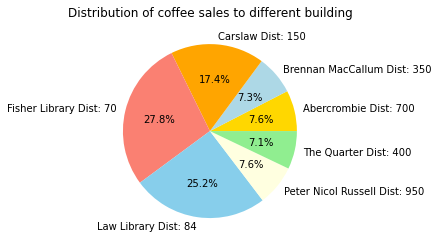

In [26]:
# sum the order_price by each distance (or building)
x_pie = bs.groupby('building_name')['order_price'].sum()

# manually combine building name and distance factors
label_bn = ['Abercrombie Dist: 700', 'Brennan MacCallum Dist: 350', 'Carslaw Dist: 150',
       'Fisher Library Dist: 70', 'Law Library Dist: 84',
       'Peter Nicol Russell Dist: 950', 'The Quarter Dist: 400']

color = ['gold','lightblue','orange','salmon','skyblue','lightyellow','lightgreen']

# Creating pie chart to visulize the difference between totals sales and distance to cafe store
plt.pie(x_pie,labels = label_bn,autopct = '%.1f%%',colors = color)
plt.title('Distribution of coffee sales to different building')
plt.show()

We can easily conclude that the closer the builiding to cafe, the higher hourly sales the shop can earn. **However, one issues must be noticed that the distance show a disminishing impact on hourly sales. That is as the farer the store away with building, the smaller impact of distance on cafe hourly sales.** This finding can be visulized by line graph.

**2.2.3** Further discovery of disminshing effect of distance in sale

In [27]:
# a new dataframe to reorganize varibles
dist_build_orderprice = bs.groupby(['dist_to_cafe','building_name'])[['order_price']].sum().sort_values(by='order_price').reset_index().sort_values(by='dist_to_cafe')
dist_build_orderprice

,dist_to_cafe,building_name,order_price
6,70,Fisher Library (F03),40300.4
5,84,Law Library (F10),36527.9
4,150,Carslaw (F07),25192.0
1,350,Brennan MacCallum (A18),10550.7
0,400,The Quarter (A16),10247.6
3,700,Abercrombie (H70),10975.9
2,950,Peter Nicol Russell (PNR),10945.9


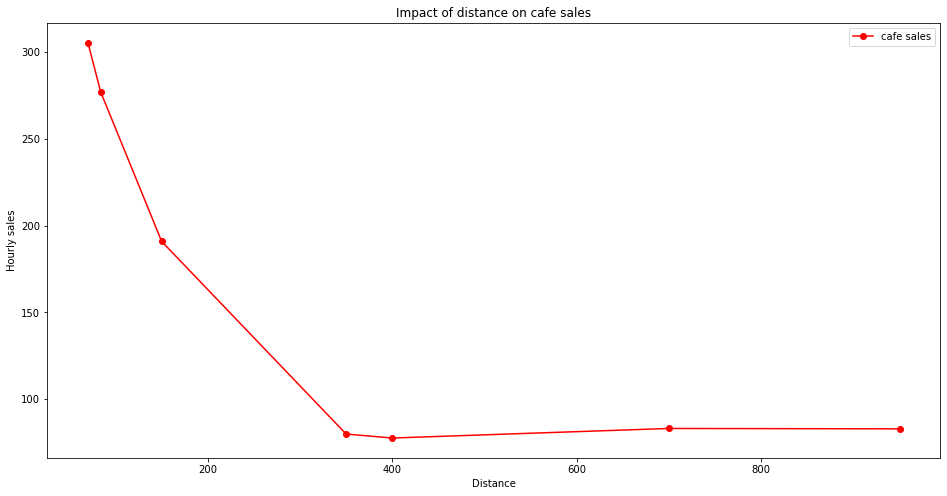

In [28]:
# y_line includes ndarray type values of 'order_price' in dataframe 'dist_build_orderprice'.
y_line = dist_build_orderprice['order_price'].to_numpy()/(154/7*6)

dist_array = dist_build_orderprice['dist_to_cafe'].to_numpy()
    
# line graph 
# x axis indicates distance
# y indicates total sales
plt.figure(figsize = (16,8))
plt.plot(dist_build_orderprice['dist_to_cafe'],y_line,marker = 'o',label = 'cafe sales',color = 'red')
autoLabel('Distance','Hourly sales','Impact of distance on cafe sales')

**2.2.4** Numeric presenting

In [29]:
for i in range(1,7):
    # Difference in coffee sold to various building
    impact = y_line[i-1]-y_line[i] 
    
    # Difference in distance
    dist_diff = np.abs(dist_array[i]-dist_array[i-1])
    
    # Per meter effects in cofe sales
    impact_perMeter = impact/dist_diff
    print('The decrease of sales per meter farer in interval [{},{}]:  {}'.format(dist_array[i-1],dist_array[i],impact_perMeter.round(2)))

The decrease of sales per meter farer in interval [70,84]:  2.04
The decrease of sales per meter farer in interval [84,150]:  1.3
The decrease of sales per meter farer in interval [150,350]:  0.55
The decrease of sales per meter farer in interval [350,400]:  0.05
The decrease of sales per meter farer in interval [400,700]:  -0.02
The decrease of sales per meter farer in interval [700,950]:  0.0


**2.2.5** Conclusion

As the above, the impact of distance is tremendously huge before 350 meters, especially in interval [70,84] and interval [84,150].

On ground of those, there are might strongly non-linear relationship between distance to cafe and coffee sales in interval [0,350] and might **slightly correlated** or **not correlated** after 350 meters far away to cafe. But this only reflect the overall correlation, will the hourly sales convey the same information need further provement.

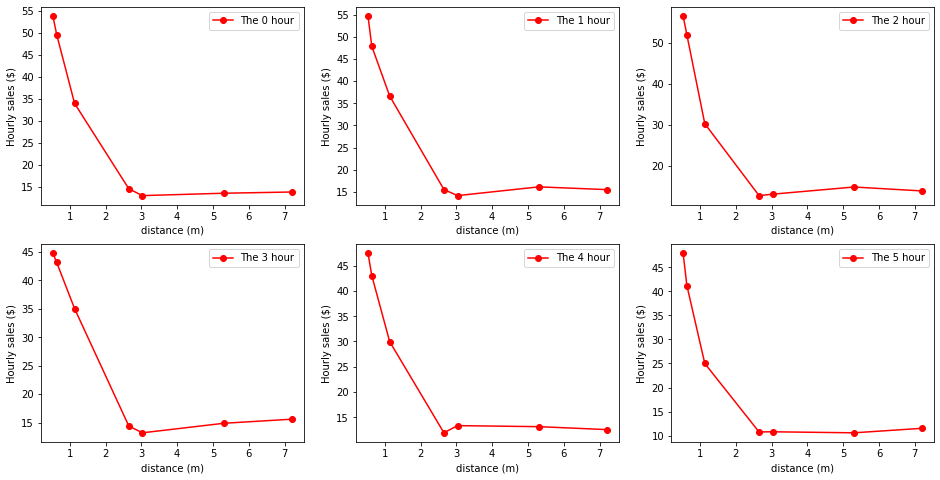

In [30]:
plt.figure(figsize = (16,8))
for i in range(0,6):
    plt.subplot(2,3,i+1)
    x_hourly = bs[bs['hours_after_open'] == i].sort_values(by = 'dist_to_cafe',ascending = False)['dist_to_cafe'].to_numpy()/(154/7*6)
    y_hourly = bs[bs['hours_after_open'] == i].sort_values(by = 'dist_to_cafe',ascending = False)['order_price'].to_numpy()/(154/7*6)
    plt.plot(x_hourly,y_hourly,marker = 'o',label = 'The {} hour'.format(i),color = 'red')
    plt.xlabel('distance (m)')
    plt.ylabel('Hourly sales ($)')
    plt.legend()

Since the total sale is segmented by opened hour into 6 parts, the trend lines show no significant difference with total coffee sale. Thus, above conclusion can be asserted: **There are might strongly non-linear relationship between distance to cafe and coffee sales in interval [0,350] and might slightly correlated or not correlated after 350 meters far away to cafe**

***2.3 Will raining affect hourly sales?***

---

**2.3.1** Reorganize dataframe

In [31]:
#Group dataset by opened hour and raining, and sum order_price
raining = cafe.groupby(['hours_after_open','raining'])[['order_price']].sum().reset_index()

#Check dataframe
raining

,hours_after_open,raining,order_price
0,0,No,17955.7
1,0,Yes,7459.8
2,1,No,20298.2
3,1,Yes,6159.7
4,2,No,17873.4
5,2,Yes,7629.9
6,3,No,19027.4
7,3,Yes,4868.0
8,4,No,16785.9
9,4,Yes,5854.5


**2.3.2** Bar chart and Numeric presenting the effect of raining

The average reduction in hourly sale due to rain is 61.68%


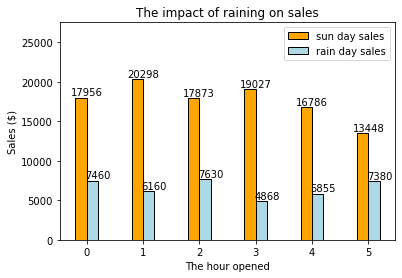

In [32]:
#Distinguish rain hour and sun hour

rain = raining[raining['raining'].isin(['Yes'])]
notRain = raining[raining['raining'].isin(['No'])]

#Graphing bar chart
#x is hour opened
#y is total sales

x_bar = np.arange(6)
w = 0.2
plt.bar(x_bar-w/2,notRain['order_price'],width = w,color ='orange',label = 'sun day sales',edgecolor = 'black')
plt.bar(x_bar+w/2,rain['order_price'],width = w,color = 'lightblue',label = 'rain day sales',edgecolor = 'black')
plt.ylim([0,27500])

#Show the amount on the top of each bar, make comparasion clear
for x,y in enumerate(notRain['order_price']):
    plt.text(x,y+300,'%s'%round(y),ha='center')
    
for x,y in enumerate(rain['order_price']):
    plt.text(x+0.2,y+300,'%s'%round(y),ha='center')
    
# autolabel (defined in previsou part)
autoLabel('The hour opened','Sales ($)','The impact of raining on sales')



def calDifference(notRaindata,raindata):
    salDec = []
    for i in range(notRaindata.shape[0]):
        diff_r_nr = (notRaindata.to_numpy()[i] - raindata.to_numpy()[i])/notRaindata.to_numpy()[i]
        salDec.append(diff_r_nr)
    return np.multiply(np.mean(salDec),100)

data_1 = calDifference(notRain['order_price'],rain['order_price'])

print('The average reduction in hourly sale due to rain is {:.2f}%'.format(data_1))

From above analyze, in raining hour, the cofe sale will reduce **approx. 62%**. But one question raised here is that if students studied in libraries near Pop-up store, would the sale still be so significant? 

**2.3.3** Introducing distance variable 

First extract useful information from dataframe 'cafe'

In [33]:
r_d = cafe.groupby(['hours_after_open','raining','dist_to_cafe'])[['order_price']].sum().reset_index()
nr = r_d[r_d['raining'].isin(['No'])]
isr = r_d[r_d['raining'].isin(['Yes'])]
nr.head()

,hours_after_open,raining,dist_to_cafe,order_price
0,0,No,70,3509.5
1,0,No,84,3413.1
2,0,No,150,3762.0
3,0,No,350,1925.7
4,0,No,400,1722.0


Separate raining dataset and not raining dataset

In [34]:
nr['dist_to_cafe'].unique()

array([ 70,  84, 150, 350, 400, 700, 950])

In [35]:
isr.head()

,hours_after_open,raining,dist_to_cafe,order_price
7,0,Yes,70,3599.8
8,0,Yes,84,3137.0
9,0,Yes,150,723.0
17,1,Yes,70,3112.3
18,1,Yes,84,2326.4


In [36]:
isr['dist_to_cafe'].unique()

array([ 70,  84, 150])

Surprisingly, in raining day, student only buy coffee when they studying at 3 libraries which are close to Pop-up store. Otherwise, student will not buy coffee in Pop-up. So, in the following discoverying, only data in these 3 libraries will be used

**2.3.4** Visulize coffee sale in sunny hours and in rainny hours to students in Fisher library, Claw library, New law library

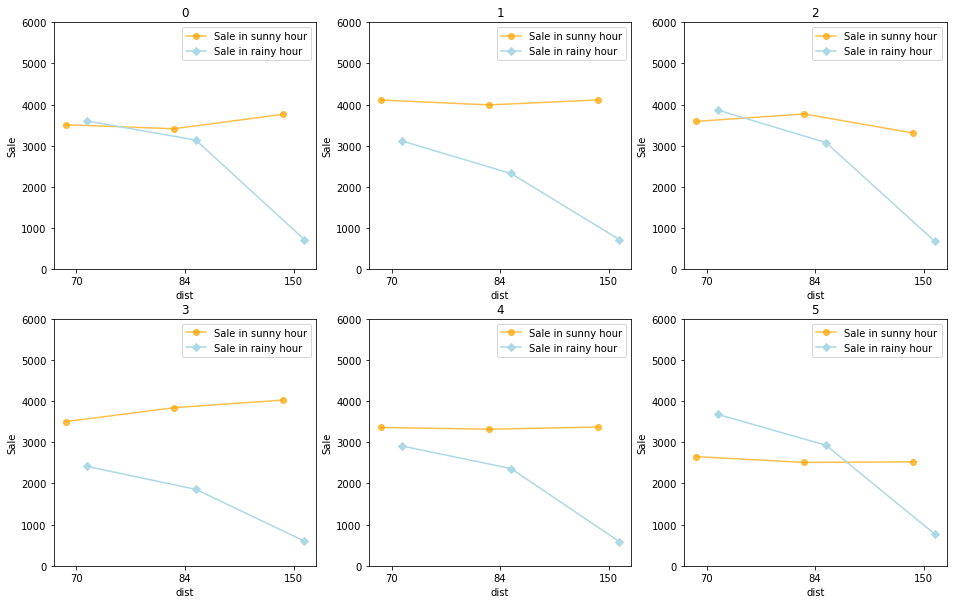

In [37]:
plt.figure(figsize = (16,10))
label_dist = ['70','84','150']
for i in range(6):
    plt.subplot(2,3,i+1)
    y_bar_sunny = nr[nr['hours_after_open'].isin([i])]['order_price']
    y_bar_rainny = isr[isr['hours_after_open'].isin([i])]['order_price']
    w_2 = 0.2
    
    plt.plot(np.arange(3)-w_2/2,y_bar_sunny[:3],label = 'Sale in sunny hour',color = 'orange',alpha = 0.7,marker='o')
    plt.plot(np.arange(3)+w_2/2,y_bar_rainny[:3],label = 'Sale in rainy hour',color = 'lightblue',marker = 'D')
    plt.xticks(np.arange(3),label_dist)
    plt.ylim([0,6000])
    autoLabel('dist','Sale','{}'.format(i))

**2.3.5** Impacts (In numeric way)

In [38]:
# order prices for head 2 close libraries in not raining hour and raining hour

nr_h2 = nr[nr['hours_after_open'].isin([0])]['order_price'][:2]
isr_h2 = isr[isr['hours_after_open'].isin([0])]['order_price'][:2]

# Calculate the percentage decrease of sale because of raining
data2 = calDifference(nr_h2,isr_h2)
data3 = calDifference(nr[nr['hours_after_open'].isin([0])]['order_price'][:3],isr[isr['hours_after_open'].isin([0])]['order_price'][:3])
data4 = calDifference(nr[nr['hours_after_open'].isin([0])]['order_price'][2:3],isr[isr['hours_after_open'].isin([0])]['order_price'][2:3])


print('The average reduction in sale due to rain in the head 2 closest libraries (< 90 meters): {:.2f}%'.format(data2))
print('The average reduction in sale due to rain in the head 3 closest libraries (< 151 meters): {:.2f}%'.format(data3))
print('The reduction in sale due to rain in the third library (150 meters far): {:.2f}%'.format(data4))

The average reduction in sale due to rain in the head 2 closest libraries (< 90 meters): 2.76%
The average reduction in sale due to rain in the head 3 closest libraries (< 151 meters): 28.77%
The reduction in sale due to rain in the third library (150 meters far): 80.78%


We can find that if the Pop-up store close to the building enough, the raining weather has slightly impact on coffee saling, and has strong impact if distance is too far. 

**2.3.6** Conclusion

According to these line graphs, the coffee sale in sunny hours are smooth to students in 3 observed libraries. In rainy hour, as farer the library to coffee shop, the less students buy coffee in Pop-up store. When the distance exccees 150 meters, or in other words, except Law library, fisher library and claw library, students will not buy coffee in Pop-up store in rainy day. Even in sunny day, there are also few students will walk a long way to buy coffee in Pop-up store. In summary, we have following findings:

        1. Raining has tremendous impact on coffee sale (62% Reduction in sale comparaing to sunny day)
        
        2. However, neglectance of the distance between coffee store and building makes that 62% meaningless.
        
        3. When consider distance:
            a. Distance between building < 100 meters:
                i) raining has slight impact on coffee sale (2.76% reduction of sale)
                
            b. 100 meters < distance < 150 meters:
               ii) Tremendous impact on sale (81% reduction)
               
            c. d > 150 meters:
              iii) Stuents do not buy coffee at Pop-up store (100% reduction)
        
        4. Hourly coffee sale ($) has non-linear relationship with raining and distance
        
        (In consideration of the non-linear relationship, we might applicate holdout in order to find the optimal hyperparameter, therefore, the statistic model will not be discussed at this part)

***2.4 The impact of seasonal factor on hourly sales - day_of_week***

---

**2.4.1** Reorganizing dataframe

In [39]:
# Sum up the total order price for each day of week and each hour

seasonal = cafe.groupby(['day_of_week','hours_after_open'])[['order_price']].sum().reset_index()

#Add a column which display day of week in values of '1.Mon-7.Sun'. This will create a meaningful order in x axis of the graph for further graphically analysis.

replace_values = {'Mon' : '1.Mon', 'Tue' : '2.Tue', 'Wed' : '3.Wed' ,'Thu':'4.Thu','Fri':'5.Fri','Sat':'6.Sat','Sun':'7.Sun'} 
seasonal = seasonal.replace({"day_of_week": replace_values}) 

# Extract list type value of average hourly coffee sales in each day of week

coffeeSale = list(seasonal.groupby('day_of_week')['order_price'].mean())

list_w = list(seasonal['day_of_week'].unique())

**2.4.2** Day of week and coffee sale

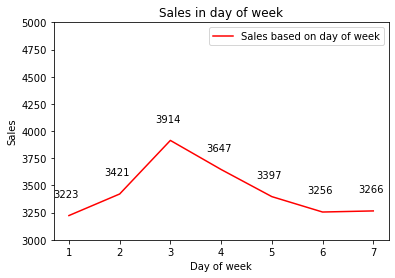

In [40]:
# x axis presents day of week from monday (1) to sunday (7)
# y axis is the total sales of each day

plt.plot(np.arange(len(list_w))+1,coffeeSale,color = 'red',label = 'Sales based on day of week')
plt.ylim([3000,5000])
autoLabel('Day of week','Sales','Sales in day of week')
for x,y in enumerate(coffeeSale):
    plt.text(x+0.7,y+200,'%s'%round(y),va='center')

In [41]:
#get correlation coefficient,Two-tailed p-value.

r, p_value = pearsonr (seasonal['day_of_week'].index,seasonal['order_price'].values)

r, p_value

(0.35143422949819525, 0.022480008528871852)

In [42]:
p_value <0.05

True

Correlation coefficient is close to zero and reject H0, suggest that there is a weak linear relationship.

**Conclusion**

We can clearly observe from the line plot and summary that the hourly sale of coffee are highest in Wendesday, Monday and the weekends have lower sales. However, the linear association bewteen those varibles is not storng. 

***2.5 The impact of seasonal factor on hourly sales - hour opened***

---

The last variable we are going to explore is hour_after_open. First let's check the sale performance in a bar chart in each hour

**2.5.1** Reorganizing dataframe

In [43]:
hourly_sale = cafe.groupby('hours_after_open')[['order_price']].sum().reset_index()
hour = list(hourly_sale['hours_after_open'].unique())
hourly_sale.style.background_gradient("Blues")

,hours_after_open,order_price
0,0,25415.500000
1,1,26457.900000
2,2,25503.300000
3,3,23895.400000
4,4,22640.400000
5,5,20827.900000


**2.5.2** Line plot

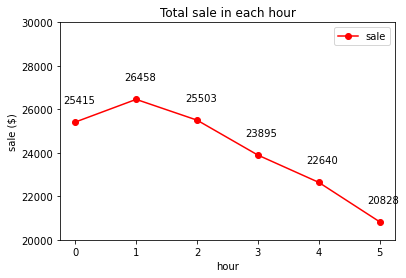

In [44]:
plt.plot(hour,hourly_sale['order_price'],color = 'red',label = 'sale',marker = 'o')
plt.ylim([20000,30000])
for x,y in enumerate(hourly_sale['order_price']):
    plt.text(x-0.2,y+1000,'%s'%round(y),va='center')
plt.grid
autoLabel('hour','sale ($)','Total sale in each hour')

We can easily observe a downward trend in sale after one hour open of store. More information will be included in statistic model 

**2.5.3** Statitic model

Something should be mentioned here is that, the sale of coffee ($) here is daily based, the data in above line plot is total houly coffee sale

In [45]:
#Insert a column of constant 1
seasonal.insert(0,'ones',1)

In [46]:
y_sea = seasonal['order_price'].to_numpy()
x_sea = seasonal[['ones','hours_after_open']].to_numpy()
result_sea = sm.OLS(y_sea,x_sea).fit()
result_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     34.07
Date:                Sun, 06 Jun 2021   Prob (F-statistic):           8.01e-07
Time:                        14:00:25   Log-Likelihood:                -295.02
No. Observations:                  42   AIC:                             594.0
Df Residuals:                      40   BIC:                             597.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3813.5306     76.212     50.038      0.000    3659.500    3967.562
x1          -146.9322     25.172     -5.837      0.000    -197.807     -96.057
==============================================================================
Omnibus:                        1.095   Durbin-Watson:                   0.671
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                0.897
Skew:                           0.349   Prob(JB):                        0.638
Kurtosis:                       2.844   Cond. No.                         5.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**2.5.4** Conclusion

According to above table, hour open and houly coffee sale in dollor is correlated with R square of 0.46. The p-value associated with coefficient is 0 means the effect of hour opened in coffee sale is statistically significant and is not due to the random variation of the sample data.

The explaination for the coef of -146.93 is that, **one more hour open of Pop-up store is associated with sale reduction of $146.93 in a normal day** 

**3. Conclusion for EDA and data analysis process**

In accordance with all above explorative analysis, we infered and concluded following results:

        1. Day opened has linear relationship with hourly coffee sale ($). One more day open is associated with $2.46 increase in sale ($)
        
        2. The impact of raining on hourly coffee sale ($) is progressively increase as the farer the libraries between Pop-up store. No coffee in Pop-up store will be bought by students who study in libraries which are 350 farer to Pop-up store. Therefore, there is non-linear relationship bewteen hourly coffee sale ($) and combination of distance and raining. 
        
        3. The impact of day_of_week on coffee sale can not be observed
        
        4. There are negative linear relationship between hour open and hourly coffee sale ($). One more hour open is associated with $146.83 decrease in hourly coffee sale ($). 

**Modelling**
---

**4.1 Reorganizing dataframe**

The referenced dataframe is 'new_df', which is summaried previously

The dataframe has 154 rows, and 2 columns (day, and average hourly sale) will be extracted to building the prediciting model

In [47]:
#Delet some columns
del new_df['0']
del new_df['1']
del new_df['2']
del new_df['3']
del new_df['4']
del new_df['5']


In [48]:
#======= add columns =======
#-------quadratic square of day -------
new_df['day^2'] = np.power(new_df['day'],2)

#------- total raining hours on a day -------
rm = cafe.groupby(['days_after_open','hours_after_open','isRaining'])[['order_price']].sum().reset_index()
rh = np.zeros(d)
for i in range(d):
    rh[i] = rm[rm['days_after_open']==i]['isRaining'].sum()
new_df['rainingHours'] = rh

#------- total dist (divided by 100) of all orders sold on a day -------
cafe['dist_to_cafe'] = cafe['dist_to_cafe']/100
d1 = cafe.groupby('days_after_open')['dist_to_cafe'].sum()
new_df['sum_dist'] = d1
new_df

,ones,day,avg_hsale,day^2,rainingHours,sum_dist
0,1,0.0,46.7,0.0,2.0,134.90
1,1,1.0,58.3,1.0,0.0,157.00
2,1,2.0,58.5,4.0,2.0,179.22
3,1,3.0,52.5,9.0,2.0,161.22
4,1,4.0,31.3,16.0,3.0,75.46
...,...,...,...,...,...,...
149,1,149.0,352.5,22201.0,3.0,793.96
150,1,150.0,350.0,22500.0,1.0,1151.88
151,1,151.0,292.5,22801.0,5.0,427.32
152,1,152.0,308.7,23104.0,2.0,912.04


In [78]:
#------- Def variables -------
x2 = new_df['day'].to_numpy().reshape(-1,1) # variable for simple linear regression
x3 = new_df[['day','day^2']].to_numpy().reshape(-1,2) # variables for polynominal regression
x4 = new_df[['day','day^2','rainingHours']].to_numpy().reshape(-1,3) # Multivariable (3) regression
y_mod = new_df['avg_hsale']

#------- Def function -------
def linReg(x,y):
    # train test split
    x_train,x_test,y_train,y_test = tts(x,y,test_size = 0.4,random_state=1)
    
    # fit variables
    lin_reg = LinearRegression()
    lin_reg.fit(x_train,y_train)
    
    # predict y by x in test set
    y_pred = lin_reg.predict(x_test) 
    
    # calculate mean squared error
    MSE = mse(y_pred,y_test) 
    
    # output coefficient(s), intercept, mean squared error
    return lin_reg.coef_,lin_reg.intercept_,MSE

#------- call funciotn -------
coef_2,intercept_2,mse_2 = linReg(x2,y_mod)
coef_3,intercept_3,mse_3 = linReg(x3,y_mod)
coef_4,intercept_4,mse_4 = linReg(x4,y_mod)

#------- print result --------
print('--- Single Variable Linear Regresion ---')
print('Coefficient of day open: {:.2f}'.format(coef_2[0])) 
print('Intercept: {:.2f}'.format(intercept_2))
print('Mean Squared Error: {:.2f}'.format(mse_2))
print('\n')
print('--- Polynominal Regression ---')
print('Coefficient of day open: {:.2f}'.format(coef_3[0]))
print('Coefficient of day open square: {:.2f}'.format(coef_3[1])) 
print('Intercept: {:.2f}'.format(intercept_3))
print('Mean Squared Error: {:.2f}'.format(mse_3))
print('\n')
print('--- Multi Variable Regression ---')
print('Coefficient of day open: {:.2f}'.format(coef_4[0]))
print('Coefficient of day open square: {:.2f}'.format(coef_4[1])) 
print('Coefficient of rainingHoura: {:.2f}'.format(coef_4[2])) 
print('Intercept: {:.2f}'.format(intercept_4))
print('Mean Squared Error: {:.2f}'.format(mse_4))

--- Single Variable Linear Regresion ---
Coefficient of day open: 2.41
Intercept: -25.38
Mean Squared Error: 1552.45


--- Polynominal Regression ---
Coefficient of day open: -0.32
Coefficient of day open square: 0.02
Intercept: 40.14
Mean Squared Error: 880.81


--- Multi Variable Regression ---
Coefficient of day open: -0.29
Coefficient of day open square: 0.02
Coefficient of rainingHoura: -6.66
Intercept: 52.25
Mean Squared Error: 760.65


# LASSO

In [50]:
x_train2,x_test2,y_train2,y_test2 = tts(new_df[['day','day^2','rainingHours','sum_dist']],new_df['avg_hsale'],test_size = 0.4,random_state = 1)

In [51]:
#fit LASSO model
lasso = LassoCV()
lasso.fit(x_train2, y_train2)
# Get results
preds_lassocv = lasso.predict(x_test2)
preds_lassocv

array([ 86.44748391,  50.13583122, 100.73308263, 342.43768951,
        52.22615409, 223.66474597, 178.18698631,  30.71237809,
        69.34323457,  57.32547502, 353.74928756, 382.13498183,
       121.89687552, 184.24130937,  33.30497946, 137.12959456,
        36.4628922 , 331.86303574, 155.81737201, 175.72802315,
       154.53604695, 266.46092599, 154.74653684, 212.77311658,
       173.6234385 ,  58.01180262,  49.03953503,  54.35425401,
        72.8592342 , 285.6786669 ,  56.23347704,  33.32701895,
       273.57475941, 231.61419818, 117.92065255, 330.67960414,
        86.83369023, 269.17072324,  79.99872301,  48.12820086,
        75.16537502, 226.51378686,  92.98583537,  46.28165433,
       276.73034276, 309.25818516, 359.93371433, 102.32195398,
        36.21622523,  64.84946649,  30.41415743,  61.58155659,
       102.7882214 ,  55.82714702,  51.23533289, 251.72366151,
       343.02498301, 240.43711306,  38.5733918 , 369.17158957,
       136.14825573, 250.13496047])

In [82]:
preds_lassocv.shape,y_test2.shape

((62,), (62,))

In [54]:
# get coefficients
# lasso has drop lost of catagories reflected in the coef number bwlow
print(lasso.intercept_)
lasso.coef_

22.762215789072343


array([-0.        ,  0.01164911,  0.        ,  0.09893395])

In [55]:
# Only 2 catagories are kept by lasso
np.sum(lasso.coef_!=0)

2

In [79]:
mse_lasso = mse(preds_lassocv,y_test2)
print(mse_lasso)

433.3165452705423


# Ridge

In [83]:
# fit ridge model
ridge=RidgeCV()
ridge.fit(x_train2, y_train2)
preds_ridge = ridge.predict(x_test2)
# get results
preds_ridge

array([ 85.20005673,  42.02951298,  94.21152941, 329.18069913,
        47.64570452, 227.98436175, 174.41022734,  48.09905547,
        81.9876464 ,  71.90028986, 342.23575976, 369.07322417,
       115.32970329, 179.27770602,  36.87223226, 137.59192731,
        48.15972572, 328.40997911, 143.58425269, 174.94415382,
       146.01313359, 264.12141585, 153.4861969 , 210.83050679,
       185.51046456,  39.81698406,  53.01818602,  49.86081369,
        67.98943255, 298.87180802,  41.76789693,  31.3424805 ,
       282.76127199, 234.5661551 , 110.11909068, 345.82177745,
        87.47218419, 278.67283969,  59.08632877,  33.19539055,
        76.44710814, 227.50832871,  94.94178089,  46.5934459 ,
       289.26001695, 316.71556172, 349.69020926, 108.55650433,
        37.17607143,  52.15925906,  41.29256623,  68.96525835,
       105.49292681,  46.40622128,  50.63095599, 256.21545124,
       345.12351836, 246.27952253,  25.34467266, 364.69803678,
       128.5361539 , 247.04326863])

In [84]:
# get coefficients
print(ridge.intercept_)
print(ridge.coef_)

-0.5443403662032438
[-9.60436161e-02  8.68194900e-03  9.48631432e+00  1.80535740e-01]


In [85]:
# Ridge has selected 4 out of 4
np.sum(ridge.coef_!=0)

4

In [86]:
mse_ridge = mse(preds_ridge,y_test2)
print(mse_ridge)

355.6400454419373


# Random forest

In [87]:
model = RandomForestRegressor(n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, x_train2.shape[1], 5),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, return_train_score=False, n_jobs=4,
                              random_state = 20)
rf_search.fit(x_train2, y_train2)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 1, 'max_features': 1} 



In [88]:
print(rf)

RandomForestRegressor(max_features=1)


In [89]:
rf.n_estimators = 100
rf.fit(x_train2, y_train2)

RandomForestRegressor(max_features=1)

In [90]:
rf_pred=rf_search.predict(x_test2)
rf_pred

array([ 67.885,  50.764,  81.524, 317.493,  56.86 , 246.372, 179.772,
        36.647,  58.178,  46.007, 328.635, 324.734, 105.429, 182.409,
        43.516, 120.395,  38.702, 333.302, 149.49 , 171.629, 134.105,
       300.926, 137.218, 210.336, 175.083,  63.142,  61.763,  47.708,
        59.323, 320.101,  59.911,  43.203, 298.992, 228.512,  99.467,
       348.458,  72.16 , 304.795,  72.393,  57.164,  67.828, 245.324,
        72.79 ,  56.991, 311.397, 333.588, 327.391,  84.053,  43.602,
        56.699,  39.239,  55.221,  85.86 ,  54.81 ,  51.826, 287.728,
       331.701, 273.075,  52.879, 334.458, 109.776, 290.007])

In [91]:
mse_rf = mse(rf_pred,y_test2)
print(mse_rf)

173.55052667741933


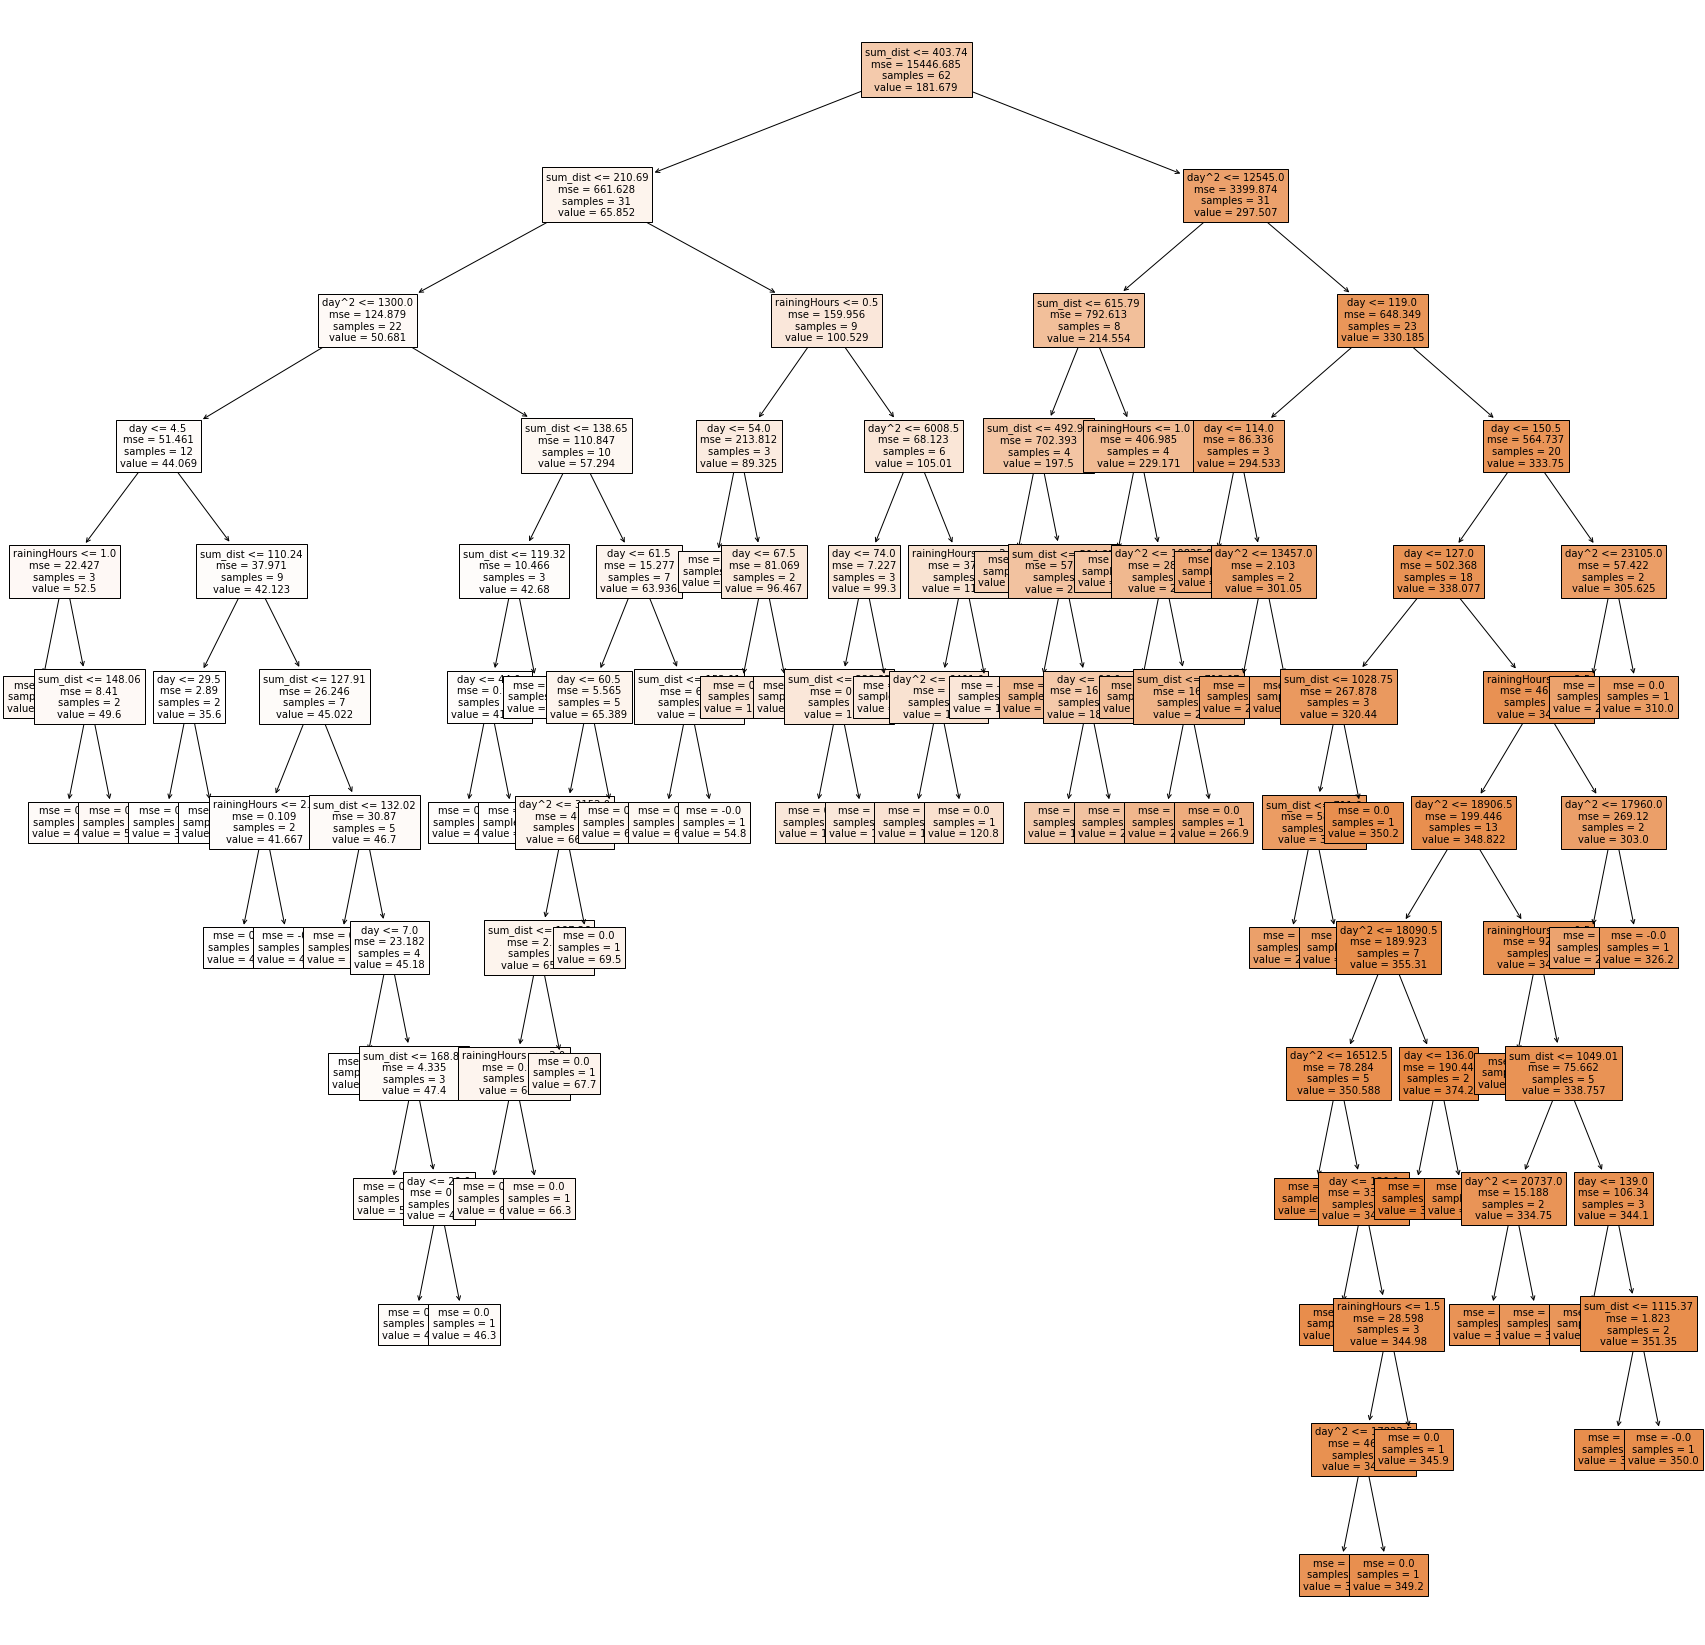

In [97]:
plt.figure(figsize=(30,30))
_ = tree.plot_tree(rf.estimators_[0], fontsize=10, feature_names=x_test2.columns, filled=True)